In [5]:
!pip install gdown



In [6]:
!gdown 1ZdhRqYv-JizWV6DxO6C4R_k1kxPhmlF2


Downloading...
From: https://drive.google.com/uc?id=1ZdhRqYv-JizWV6DxO6C4R_k1kxPhmlF2
To: /content/multiclass.csv
100% 14.6k/14.6k [00:00<00:00, 25.5MB/s]


In [7]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [8]:
csv_files = glob.glob("*.csv") + glob.glob("*.CSV")
if len(csv_files) == 0:
    txt_files = glob.glob("*.txt") + glob.glob("*.tsv")
    xlsx_files = glob.glob("*.xlsx") + glob.glob("*.xls")
    files = txt_files + xlsx_files
else:
    files = csv_files

if not files:
    print("No CSV/TSV/XLSX found in the working dir. Files present:")
    !ls -la
    raise FileNotFoundError("No dataset file found.")


In [9]:
data_file = files[0]
print(f"Using file: {data_file}")

ext = os.path.splitext(data_file)[1].lower()
if ext in ['.csv', '.txt', '.tsv']:
    try:
        if ext == '.csv':
            df = pd.read_csv(data_file, low_memory=False)
        else:
            df = pd.read_csv(data_file, sep=None, engine='python', low_memory=False)
    except Exception as e:
        print("First read failed, trying utf-8:", e)
        df = pd.read_csv(data_file, engine='python', encoding='utf-8', low_memory=False)
elif ext in ['.xlsx', '.xls']:
    df = pd.read_excel(data_file)
else:
    df = pd.read_table(data_file, engine='python', low_memory=False)


Using file: multiclass.csv


In [10]:
print("\n=== Basic info ===")
print("Shape:", df.shape)
display(df.head())
print("\nColumn dtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())



=== Basic info ===
Shape: (440, 8)


,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,class
0,3,12669,9656,7561,214,2674,1338,2
1,3,7057,9810,9568,1762,3293,1776,2
2,3,6353,8808,7684,2405,3516,7844,2
3,3,13265,1196,4221,6404,507,1788,1
4,3,22615,5410,7198,3915,1777,5185,1



Column dtypes:
 Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
class               int64
dtype: object

Missing values per column:
 Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
class               0
dtype: int64


In [11]:
# Fill missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col].fillna(df[col].median(), inplace=True)  # numeric → median
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)  # categorical → mode


In [12]:
# Try to auto-detect target column
possible_targets = ['Category','Label','target','class','Purchased']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break
if target_col is None:
    target_col = df.columns[-1]  # fallback = last column
print("Target column:", target_col)


Target column: class


In [13]:
X = df.drop(columns=[target_col])
y = df[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Sample target values:\n", y.value_counts().head())


X shape: (440, 7)
y shape: (440,)
Sample target values:
 class
2    180
3    173
1     87
Name: count, dtype: int64


In [17]:
# One-hot encode categorical features
X = pd.get_dummies(X)

# Encode target if categorical
if isinstance(y, pd.Series) and (y.dtype == 'object' or y.nunique() < 20):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y)) < 20 else None
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (352, 7) Test shape: (88, 7)


In [20]:
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)
print("\nSaved X_train.npy, X_test.npy, y_train.npy, y_test.npy in working dir.")



Saved X_train.npy, X_test.npy, y_train.npy, y_test.npy in working dir.


KNN IMPLEMENTATION


In [21]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score


In [22]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


In [23]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        # Step 1: distances to all training samples
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Step 2: find k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        k_labels = [self.y_train[i] for i in k_indices]
        # Step 3: majority vote
        most_common = Counter(k_labels).most_common(1)
        return most_common[0][0]


In [25]:
from sklearn.model_selection import train_test_split

# Suppose last column is target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)



Training set size: (352, 7)
Testing set size: (88, 7)


In [33]:
clf = KNN(k=5)
clf.fit(X_train, y_train)

# Predict first 5 test samples
sample_preds = clf.predict(X_test[:5])
print("First 5 predictions:", sample_preds)
print("Actual labels:", y_test[:5])


First 5 predictions: [2 3 2 1 3]
Actual labels: [2 3 2 2 3]


In [32]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

y_pred = clf.predict(X_test)
print("Model Accuracy:", accuracy(y_test, y_pred))


Model Accuracy: 0.9204545454545454


In [29]:
from sklearn.metrics import classification_report

# Predictions from scratch KNN
y_pred = clf.predict(X_test)

# Generate classification report
print("Classification Report (Scratch KNN):")
print(classification_report(y_test, y_pred))


Classification Report (Scratch KNN):
              precision    recall  f1-score   support

           1       0.87      0.81      0.84        16
           2       0.97      0.92      0.95        39
           3       0.92      1.00      0.96        33

    accuracy                           0.93        88
   macro avg       0.92      0.91      0.91        88
weighted avg       0.93      0.93      0.93        88



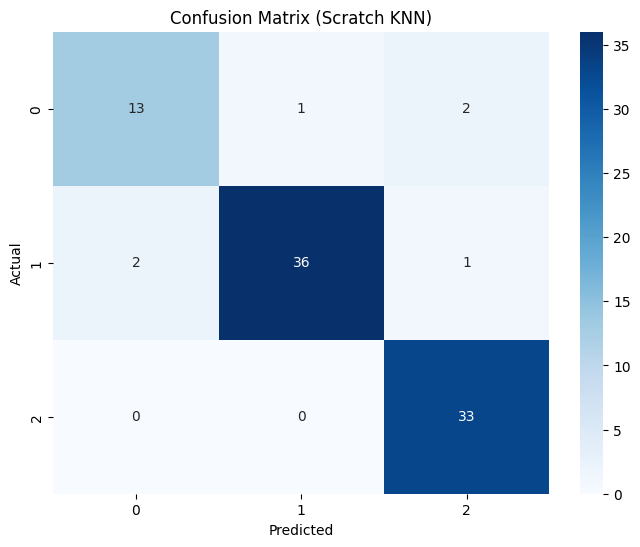

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Scratch KNN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


KNN with scikit-learn


In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries imported successfully.")


Libraries imported successfully.


In [35]:
knn_sklearn = KNeighborsClassifier(n_neighbors=5)  # You can change k
print(knn_sklearn)


KNeighborsClassifier()


In [36]:
knn_sklearn.fit(X_train, y_train)
print("KNN (sklearn) model trained.")


KNN (sklearn) model trained.


In [37]:
y_pred_sklearn = knn_sklearn.predict(X_test)

# Show first 5 predictions vs actual
print("First 5 predictions:", y_pred_sklearn[:5])
print("Actual labels:       ", y_test[:5])


First 5 predictions: [2 3 2 1 3]
Actual labels:        [2 3 2 2 3]


In [38]:
acc = accuracy_score(y_test, y_pred_sklearn)
print("KNN (sklearn) Accuracy:", acc)


KNN (sklearn) Accuracy: 0.9204545454545454


In [39]:
print("Classification Report (KNN sklearn):")
print(classification_report(y_test, y_pred_sklearn))


Classification Report (KNN sklearn):
              precision    recall  f1-score   support

           1       0.81      0.81      0.81        16
           2       0.97      0.90      0.93        39
           3       0.92      1.00      0.96        33

    accuracy                           0.92        88
   macro avg       0.90      0.90      0.90        88
weighted avg       0.92      0.92      0.92        88



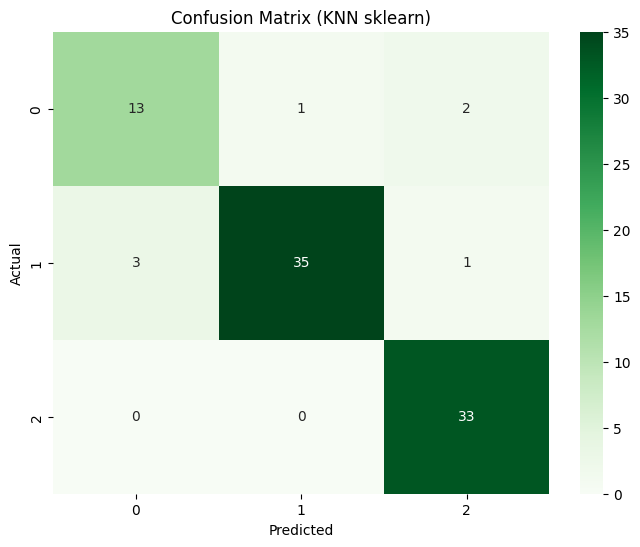

In [40]:
cm = confusion_matrix(y_test, y_pred_sklearn)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (KNN sklearn)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [41]:
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f"k={k}, Accuracy={accuracy_score(y_test, y_pred):.3f}")


k=1, Accuracy=0.909
k=2, Accuracy=0.875
k=3, Accuracy=0.920
k=4, Accuracy=0.886
k=5, Accuracy=0.920
k=6, Accuracy=0.909
k=7, Accuracy=0.909
k=8, Accuracy=0.909
k=9, Accuracy=0.909
k=10, Accuracy=0.898
